<a href="https://colab.research.google.com/github/kanru-wang/GAN_and_Diffusion_models/blob/main/CelebA_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer, Reshape, LeakyReLU, Dropout, Conv2DTranspose, Add, Conv2D,
    MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
)
from tensorflow.keras.optimizers import Adam

# Data

## Download Data

Before running the following cell, must first log into Kaggle, go to `Settings -> API -> Create New Token`.

Download `kaggle.json` and upload it to the root folder of Colab. 

In [2]:
# suppress output
%%capture
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/celeba-dataset
! unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

## Prepare Data

In [3]:
BATCH_SIZE = 128
IM_SHAPE = (64, 64, 3)
LEARNING_RATE = 2e-4
LATENT_DIM = 100
EPOCHS = 50  # 1000

def preprocess(image):
    return tf.cast(image, tf.float32) / 127.5 - 1.0

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/img_align_celeba/img_align_celeba",
    label_mode=None,
    image_size=(IM_SHAPE[0], IM_SHAPE[1]),
    batch_size=BATCH_SIZE
)

dataset

Found 202599 files belonging to 1 classes.


<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [4]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

for d in train_dataset.take(1):
    print(d.shape)

(128, 64, 64, 3)


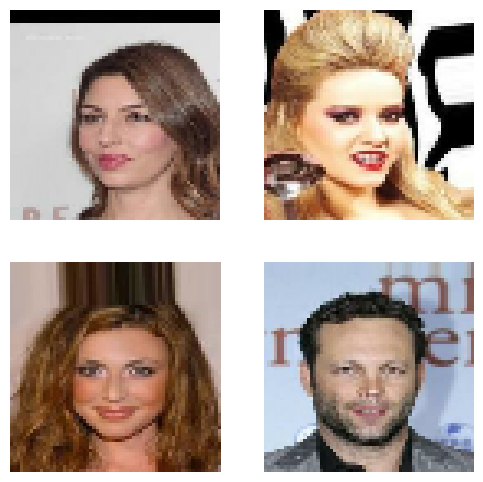

In [5]:
plt.figure(figsize=(6, 6))
k = 0
n = 4
for i in range(n):
    ax = plt.subplot(2, 2, k+1)
    plt.imshow((d[i] + 1) / 2)
    plt.axis("off")
    k += 1

# Modeling

In [6]:
generator = tf.keras.Sequential([
    Input(shape=(LATENT_DIM,)),
    Dense(4 * 4 * LATENT_DIM),
    Reshape((4, 4, LATENT_DIM)),

    Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(3, kernel_size=4, strides=2, activation=tf.keras.activations.tanh, padding="same"),
], name="generator")

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        819712    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      20

In [7]:
discriminator = tf.keras.Sequential([
    Input(shape=(IM_SHAPE[0], IM_SHAPE[1], 3)),

    Conv2D(64, kernel_size=4, strides=2, padding="same"),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size=4, strides=2, padding="same"),
    BatchNormalization(),
    LeakyReLU(0.2),
    
    Conv2D(256, kernel_size=4, strides=2, padding="same"),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(1, kernel_size=4, strides=2, padding="same"),

    Flatten(),
    Dense(1, activation="sigmoid")
], name="discriminator")

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                     

In [8]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim


    def on_epoch_end(self, epoch, logs=None):
        n = 6
        k = 0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16, 16))
        for i in range(n):
            for j in range(n):
                ax=plt.subplot(n, n, k + 1)
                plt.imshow((out[k] + 1) / 2,)
                plt.axis("off")
                k += 1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch + 1))


class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator


    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")


    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]


    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        ### Discriminator ###
        random_noise = tf.random.normal(shape=(batch_size, LATENT_DIM))
        fake_images = self.generator(random_noise)
        # Use soft/noisy labels according to https://github.com/soumith/ganhacks
        real_labels = (
            tf.ones((batch_size, 1))
            + 0.25 * tf.random.uniform((batch_size, 1), minval=-1, maxval=1)
        )
        fake_labels = (
            tf.zeros((batch_size, 1))
            + 0.25 * tf.random.uniform((batch_size, 1),)
        )
        with tf.GradientTape() as recorder:
            real_predictions = self.discriminator(real_images)
            d_loss_real = self.loss_fn(real_labels, real_predictions)
            fake_predictions = self.discriminator(fake_images)
            d_loss_fake = self.loss_fn(fake_labels, fake_predictions)
            d_loss = d_loss_real + d_loss_fake
        partial_derivatives = recorder.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(partial_derivatives, self.discriminator.trainable_weights)
        )

        ### Generator ###
        random_noise = tf.random.normal(shape=(batch_size, LATENT_DIM))
        flipped_fake_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as recorder:
            fake_predictions = self.discriminator(self.generator(random_noise))
            g_loss = self.loss_fn(flipped_fake_labels, fake_predictions)
        partial_derivatives = recorder.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(partial_derivatives, self.generator.trainable_weights)
        )

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {
            "d_loss":self.d_loss_metric.result(),
            "g_loss":self.g_loss_metric.result()
        }

In [ ]:
gan = GAN(discriminator, generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

!mkdir generated

history = gan.fit(train_dataset, epochs=EPOCHS, callbacks=[ShowImage(LATENT_DIM)])

Epoch 1/50
      6/Unknown - 24s 166ms/step - d_loss: 1.1675 - g_loss: 0.6651

1582/1582 [==============================] - 308s 180ms/step - d_loss: 1.1575 - g_loss: 0.9613
Epoch 2/50
1582/1582 [==============================] - 288s 182ms/step - d_loss: 1.1933 - g_loss: 0.8997
Epoch 3/50
1582/1582 [==============================] - 288s 182ms/step - d_loss: 1.2191 - g_loss: 0.8497
Epoch 4/50
1582/1582 [==============================] - 288s 181ms/step - d_loss: 1.2291 - g_loss: 0.8382
Epoch 5/50
1582/1582 [==============================] - 288s 182ms/step - d_loss: 1.2212 - g_loss: 0.8414
Epoch 6/50
1582/1582 [==============================] - 287s 181ms/step - d_loss: 1.2170 - g_loss: 0.8496
Epoch 7/50
1582/1582 [==============================] - 287s 181ms/step - d_loss: 1.2077 - g_loss: 0.8664
Epoch 8/50
1582/1582 [==============================] - 287s 181ms/step - d_loss: 1.1945 - g_loss: 0.8725
Epoch 9/50
1582/1582 [==============================] - 289s 182ms/step - d_loss: 1.1872 - g_loss: 0.8840
Epoch 10/50
1582/1582 [==============================] - 

<ipython-input-8-74d561bbfbbd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 16))


1582/1582 [==============================] - 287s 181ms/step - d_loss: 1.1573 - g_loss: 0.9058
Epoch 22/50
1582/1582 [==============================] - 287s 181ms/step - d_loss: 1.1540 - g_loss: 0.9098
Epoch 23/50
1582/1582 [==============================] - 287s 181ms/step - d_loss: 1.1562 - g_loss: 0.9107
Epoch 24/50
1582/1582 [==============================] - 287s 181ms/step - d_loss: 1.1559 - g_loss: 0.9151
Epoch 25/50
1582/1582 [==============================] - 286s 180ms/step - d_loss: 1.1390 - g_loss: 0.9265
Epoch 26/50
1582/1582 [==============================] - 286s 180ms/step - d_loss: 1.1513 - g_loss: 0.9238
Epoch 27/50
1582/1582 [==============================] - 286s 181ms/step - d_loss: 1.1346 - g_loss: 0.9328
Epoch 28/50
1582/1582 [==============================] - 286s 181ms/step - d_loss: 1.1312 - g_loss: 0.9409
Epoch 29/50
1582/1582 [==============================] - 288s 182ms/step - d_loss: 1.1226 - g_loss: 0.9488
Epoch 30/50
1582/1582 [==========================

In [ ]:
plt.plot(history.history["d_loss"])
plt.plot(history.history["g_loss"])
plt.title("GAN Loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["d_loss", "g_loss"], loc="upper left")
plt.show()